## Extracting Embeddings from All Layers

The key insight of our approach is to probe **every layer** of the model, not just the final output. We use PyTorch forward hooks to capture the hidden states from each transformer block.

This code works for any Hugging Face vision transformer. Forward hooks are a powerful technique for "opening up" models and inspecting their internal representations.

In [1]:
import torch
import numpy as np
from transformers import AutoModel, AutoImageProcessor
from PIL import Image
from pathlib import Path
from tqdm.auto import tqdm

# Load model and processor
model_name = "facebook/dinov2-giant" # In our paper, we call this DINOv2 Huge
model = AutoModel.from_pretrained(model_name)
processor = AutoImageProcessor.from_pretrained(model_name)

num_layers = len(model.encoder.layer) # dynamically gets the number of layers
print(f"Model has {num_layers} layers")

def extract_all_layer_embeddings(model, processor, image):
    """Extract embeddings from all layers using forward hooks."""
    num_layers = len(model.encoder.layer)
    activations = {}
    handles = []

    def make_hook(layer_idx):
        def hook(module, input, output):
            if isinstance(output, tuple):
                hidden_states = output[0]
            else:
                hidden_states = output
            # Mean over patch tokens (excluding CLS token at position 0)
            if hidden_states.dim() == 3:
                activations[layer_idx] = hidden_states[:, 1:, :].mean(dim=1).detach()
            else:
                activations[layer_idx] = hidden_states.detach()
        return hook

    # Register hooks on all layers
    for i, layer in enumerate(model.encoder.layer):
        handle = layer.register_forward_hook(make_hook(i))
        handles.append(handle)

    # Run forward pass
    inputs = processor(images=image, return_tensors="pt")
    with torch.no_grad():
        model(**inputs)

    # Clean up hooks
    for handle in handles:
        handle.remove()

    # Stack all layer embeddings: (num_layers, hidden_dim)
    embeddings = torch.stack([activations[i].squeeze(0) for i in range(num_layers)])
    return embeddings

/Users/sebastian/Developer/mental_rotations_gifs/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Loading weights: 100%|██████████| 727/727 [00:00<00:00, 1438.20it/s, Materializing param=layernorm.weight]                                 
The image processor of type `BitImageProcessor` is now loaded as a fast processor by default, even if the model checkpoint was saved with a slow processor. This is a breaking change and may produce slightly different outputs. To continue using the slow processor, instantiate this class with `use_fast=False`. 


Model has 40 layers


Now we process all frames of our rotating object and save the embeddings:

In [2]:
# Get frame paths
frames_dir = Path("frames")
frame_paths = sorted(frames_dir.glob("frame_*.png"))
print(f"Found {len(frame_paths)} frames")

# Process all frames
all_embeddings = []
frame_names = []

for path in tqdm(frame_paths, desc="Extracting embeddings"):
    image = Image.open(path)
    embeddings = extract_all_layer_embeddings(model, processor, image)
    all_embeddings.append(embeddings)
    frame_names.append(path.name)

# Stack: (num_frames, num_layers, hidden_dim)
all_embeddings = torch.stack(all_embeddings)
print(f"All embeddings shape: {all_embeddings.shape}")

# Save to npz file
output_file = "embeddings.npz"
np.savez(
    output_file,
    embeddings=all_embeddings.numpy(),
    frame_names=np.array(frame_names),
    model_name=model_name,
    num_layers=num_layers
)
print(f"Saved to {output_file}")

Found 72 frames


Extracting embeddings: 100%|██████████| 72/72 [00:46<00:00,  1.54it/s]

All embeddings shape: torch.Size([72, 40, 1536])
Saved to embeddings.npz


## Visualizing the Latent Trajectory

The most satisfying part: watching an object trace a circle through embedding space as it rotates.

We use PCA to project the high-dimensional embeddings down to 2D, then color each point by its rotation angle. If the model has learned an equivariant representation, we should see a smooth, circular path.

Embeddings shape: (72, 40, 1536)
Number of layers: 40
Explained variance: 65.9%


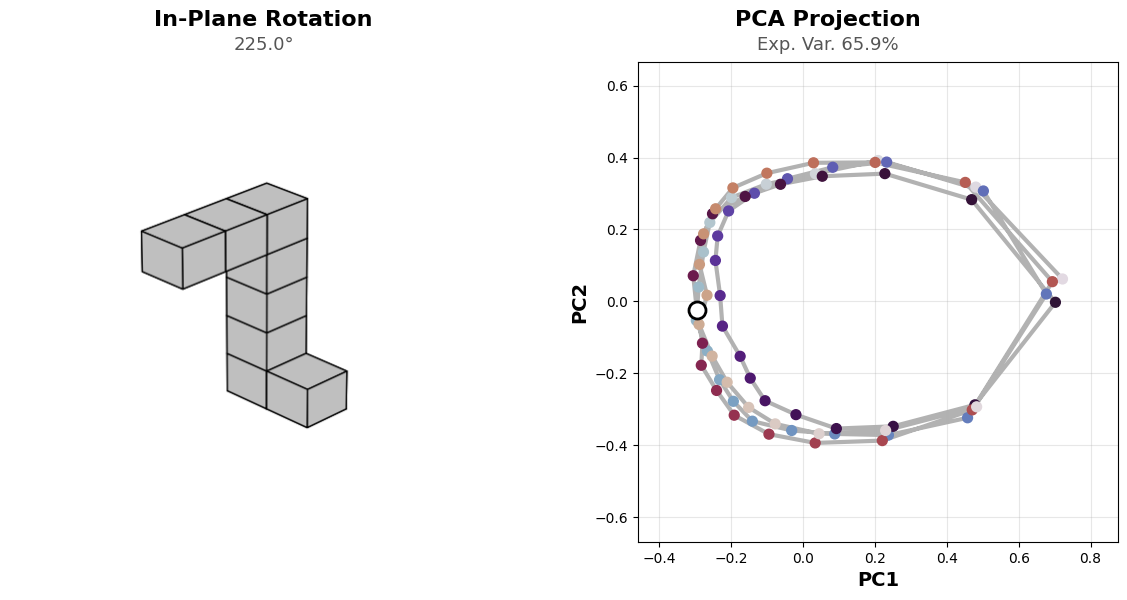

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from pathlib import Path
from PIL import Image

# Load the embeddings
data = np.load("embeddings.npz")
embeddings = data["embeddings"]  # shape: (num_frames, num_layers, hidden_dim)
num_layers = int(data["num_layers"])
num_frames = embeddings.shape[0]

print(f"Embeddings shape: {embeddings.shape}")
print(f"Number of layers: {num_layers}")

# Select a layer to visualize
layer = 18
layer_embeddings = embeddings[:, layer, :]

# PCA projection to 2D
pca = PCA(n_components=2)
projected = pca.fit_transform(layer_embeddings)
explained_var = pca.explained_variance_ratio_.sum() * 100

print(f"Explained variance: {explained_var:.1f}%")

# Create rotation angles for coloring
angles = np.linspace(0, 360, num_frames, endpoint=False)

# Load frame images
frames_dir = Path("frames")
frame_paths = sorted(frames_dir.glob("frame_*.png"))
images = [Image.open(p) for p in frame_paths]

# Compute axis limits (square, centered)
pad = 0.15
x_min, x_max = projected[:, 0].min(), projected[:, 0].max()
y_min, y_max = projected[:, 1].min(), projected[:, 1].max()
x_range = x_max - x_min
y_range = y_max - y_min
max_range = max(x_range, y_range)
center_x = (x_min + x_max) / 2
center_y = (y_min + y_max) / 2

pca_xlim = (center_x - max_range/2 - pad*max_range, center_x + max_range/2 + pad*max_range)
pca_ylim = (center_y - max_range/2 - pad*max_range, center_y + max_range/2 + pad*max_range)

# Select a frame to highlight
current_frame = 45

# Plot side-by-side
fig, (ax_img, ax_pca) = plt.subplots(1, 2, figsize=(12, 6))
fig.subplots_adjust(left=0.02, right=0.98, top=0.88, bottom=0.08, wspace=0.20)

# Add figure-level titles
title_y = 0.94
fig.text(0.25, title_y, "In-Plane Rotation", fontsize=16, fontweight='bold', ha='center')
fig.text(0.25, title_y - 0.04, f"{angles[current_frame]:.1f}°", fontsize=13, ha='center', color='#555555')
fig.text(0.72, title_y, "PCA Projection", fontsize=16, fontweight='bold', ha='center')
fig.text(0.72, title_y - 0.04, f"Exp. Var. {explained_var:.1f}%", fontsize=13, ha='center', color='#555555')

# Left: current frame image
ax_img.imshow(images[current_frame])
ax_img.axis('off')

# Right: PCA plot
ax_pca.plot(projected[:, 0], projected[:, 1], color='gray', alpha=0.6, linewidth=3, zorder=1)
ax_pca.scatter(projected[:, 0], projected[:, 1], c=angles, cmap="twilight", s=50, vmin=0, vmax=360, zorder=2)
ax_pca.scatter(projected[current_frame, 0], projected[current_frame, 1], 
               c='white', s=150, edgecolors='black', linewidths=2, zorder=3)

ax_pca.set_xlabel("PC1", fontsize=14, fontweight='bold')
ax_pca.set_ylabel("PC2", fontsize=14, fontweight='bold')
ax_pca.set_xlim(pca_xlim)
ax_pca.set_ylim(pca_ylim)
ax_pca.set_aspect('equal', adjustable='box')
ax_pca.grid(True, alpha=0.3)

plt.show()